# Summary

# Imports

In [1]:
%run _imports.ipynb

Setting the PACKAGE_VERSION environment variable.
Setting the DOCS_SECRET_KEY environment variable.
Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2018-04-09 14:33:57.956070


In [2]:
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

torch.cuda.set_device(0)

In [4]:
import pagnn

# Parameters

In [5]:
NOTEBOOK_NAME = 'optimize_gan_architecture'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()
NOTEBOOK_PATH.mkdir(exist_ok=True)

In [6]:
seq = pagnn.utils.random_sequence(64, 20, 43)

In [7]:
conv1 = nn.Conv1d(20, 32, kernel_size=4, stride=2, padding=2)

In [8]:
conv1(Variable(seq)).shape

torch.Size([64, 32, 22])

In [9]:
pagnn.datavargan.conv2d_shape((43, 43), 4, 2, 1)

(21, 21)

In [10]:
torch.__version__

'0.4.0a0+1ab248d'

#### `conv1d_xtimes_shape`

In [50]:
def conv1d_xtimes_shape(in_channels, n_times, kernel_size=1, stride=1, padding=0, dilation=1):
    out_channels = in_channels
    for _ in range(n_times):
        out_channels = pagnn.utils.conv1d_shape(
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
        )
    return out_channels

In [51]:
conv1d_xtimes_shape(64, 4, kernel_size=4, stride=2, padding=1)

4

## Functions

In [52]:
def plot_losses(losses, lengths):
    x = np.arange(len(losses))
    # y_lowess = lowess(losses, x, frac=0.1, return_sorted=False)

    plt.plot(x[lengths % 2 == 0], losses[lengths % 2 == 0], 'o-', label='even', alpha=0.5)
    plt.plot(x[lengths % 2 != 0], losses[lengths % 2 != 0], 'o-', label='odd', alpha=0.5)
    # plt.plot(x, y_lowess, label='fit', color='k', linewidth=2)

    plt.title(f'Loss: {losses[-20:].mean():.5f}', fontsize=18)
    plt.legend(loc='upper right')
   
    
def plot_accuarcy(scores, edges_edit_scores, lengths):
    x = np.arange(len(scores))
    y_lowess = lowess(scores, x, frac=0.1, return_sorted=False)

    plt.plot(x[lengths % 2 == 0], scores[lengths % 2 == 0], '.-', label='even', alpha=0.5)
    plt.plot(x[lengths % 2 != 0], scores[lengths % 2 != 0], '.-', label='odd', alpha=0.5)

    plt.plot(x[lengths % 2 == 0], edges_edit_scores[lengths % 2 == 0], '.-', label='even edges', alpha=0.5)
    plt.plot(x[lengths % 2 != 0], edges_edit_scores[lengths % 2 != 0], '.-', label='odd edges', alpha=0.5)

    plt.title(f'Accuracy: {scores[-20:].mean():.5f}', fontsize=18)
    plt.legend(loc='lower right')

    
def hist_output(out, range_):
    plt.hist(out.view(-1).cpu().data.numpy(), bins=20, range=range_)
    plt.yscale('log', nonposy='clip')
    plt.ylabel("Number of points\n(number of amino acids x 20)")
    plt.xlabel("Predicted score")

# Random sequence

## Settings

In [44]:
importlib.reload(pagnn.models)

<module 'pagnn.models' from '/home/kimlab1/strokach/working/pagnn/pagnn/models/__init__.py'>

In [45]:
n_layers = 4
bottleneck_size = 64
batch_size = 256
min_seq_len = 64
max_seq_len = 256
n_iters = 3_000

Network = pagnn.models.AEBasicConvDeconv
# Network = pagnn.models.AEBasicPoolPixelShuffle
# Network = pagnn.models.AEBasicPoolUpsample

uniqie_id = '-'.join([
    f'{Network.__name__}',
    f'{n_layers}layers',
    f'{min_seq_len}to{max_seq_len}length',
    f'{bottleneck_size}bottleneck',
    f'{batch_size}batch',
])
print(uniqie_id)

AEBasicConvDeconv_4layers_64to256length_64bottleneck_256batch


In [46]:
net = Network(n_layers=n_layers, bottleneck_size=bottleneck_size).cuda()
loss_fn = nn.BCELoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

0


## Run

In [ ]:
# Run
seed = 42
random_state = np.random.RandomState(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

lengths = []
scores = []
edges_edit_scores = []
losses = []

for i in tqdm.tqdm_notebook(range(n_iters), total=n_iters):
    optimizer.zero_grad()
    
    x_list = []
    adjs = []
    for j in range(batch_size):
        n_aa = random_state.randint(min_seq_len, max_seq_len)
        # n_aa = 21
        xd = pagnn.utils.random_sequence(1, 20, n_aa, random_state).cuda()
        adj = net.get_adjs(xd)
        assert adj[0] == xd.shape[2]
        x_list.append(xd)
        adjs.append(adj)

    seq = torch.cat(x_list, 2)
   
    out = net(seq, adjs)

    loss = loss_fn(out.view(-1, 1), seq.view(-1, 1))
    loss.backward()
    
    optimizer.step()

    losses.append(loss.mean().cpu().data.numpy())
    lengths.append(n_aa)

    out_argmax = pagnn.utils.argmax_onehot(out.data)
    edit_score = pagnn.utils.score_edit(seq[0, :, :].data, out_argmax)
    scores.append(edit_score)

    seq_edges = []
    out_edges = []
    start = 0
    for adj in adjs:
        seq_len = adj[0].shape[1]
        stop = start + seq_len
        seq_edges.extend([seq[:, :, start:start + 5], seq[:, :, stop - 5:stop]])
        out_edges.extend([out[:, :, start:start + 5], out[:, :, stop - 5:stop]])
        start = stop
    assert start == seq.shape[2]
    seq_edges = torch.cat(seq_edges, 2)
    out_edges = torch.cat(out_edges, 2)

    out_edges_argmax = pagnn.utils.argmax_onehot(out_edges.data)
    edges_edit_score = pagnn.utils.score_edit(seq_edges[0, :, :].data, out_edges_argmax)
    edges_edit_scores.append(edges_edit_score)

    if i % 100 == 0:
        print(f'{edges_edit_score:.5f}')

In [760]:
losses = np.array(losses).squeeze()
scores = np.vstack(scores).squeeze()
edges_edit_scores = np.vstack(edges_edit_scores).squeeze()
lengths = np.vstack(lengths).squeeze()

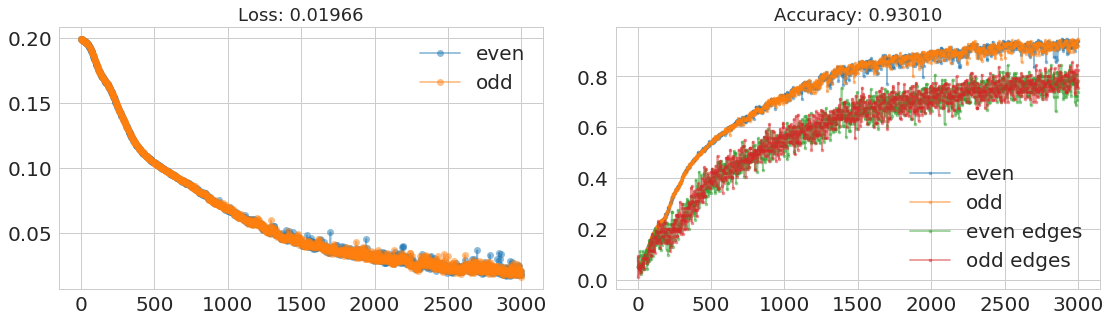

In [696]:
# Plot 1
fg, axs = plt.subplots(1, 2, figsize=(16, 5))

# === Loss ===
plt.sca(axs[0])
plot_losses(losses, lengths)

# === Accuracy ===
plt.sca(axs[1])
plot_accuarcy(scores, edges_edit_scores, lengths)

plt.tight_layout()
plt.savefig(NOTEBOOK_PATH.joinpath(f'{uniqie_id}-random_seq-loss_acc.pdf').as_posix(), bbox_inches='tight')
plt.savefig(NOTEBOOK_PATH.joinpath(f'{uniqie_id}-random_seq-loss_acc.png').as_posix(), dpi=72, bbox_inches='tight')

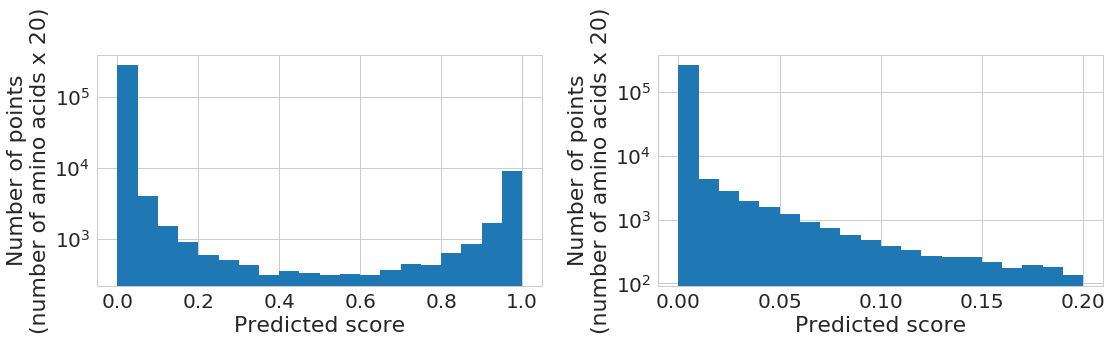

In [697]:
# Plot 2 
fg, axs = plt.subplots(1, 2, figsize=(16, 5))

# 
plt.sca(axs[0])
hist_output(out, None)

plt.sca(axs[1])
hist_output(out, (0, 0.2))

plt.tight_layout()
# plt.savefig(NOTEBOOK_PATH.joinpath(f'{uniqie_id}_hist.pdf').as_posix(), bbox_inches='tight')
# plt.savefig(NOTEBOOK_PATH.joinpath(f'{uniqie_id}_hist.png').as_posix(), dpi=72, bbox_inches='tight')

# Real sequence

## Settings

In [14]:
importlib.reload(pagnn.models)

<module 'pagnn.models' from '/home/kimlab1/strokach/working/pagnn/pagnn/models/__init__.py'>

In [16]:
n_layers = 4
bottleneck_size = 32
batch_size = 256
min_seq_len = 64
max_seq_len = 256
n_iters = 3000

Network = pagnn.models.AEBasicConvDeconv
# Network = pagnn.models.AEBasicPoolPixelShuffle
# Network = pagnn.models.AEBasicPoolUpsample

uniqie_id = '-'.join([
    f'{Network.__name__}',
    f'{n_layers}layers',
    f'{min_seq_len}to{max_seq_len}length',
    f'{bottleneck_size}bottleneck',
    f'{batch_size}batch',
])
print(uniqie_id)

AEBasicConvDeconv_4layers_64to256length_32bottleneck_256batch


In [17]:
net = Network(n_layers=n_layers, bottleneck_size=bottleneck_size).cuda()
loss_fn = nn.BCELoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

0


## Run

In [18]:
import pagnn.training.gan.main

import pagnn.dataset
import pagnn.datavargan

In [19]:
importlib.reload(pagnn.dataset)
importlib.reload(pagnn.datavargan)

<module 'pagnn.datavargan' from '/home/kimlab1/strokach/working/pagnn/pagnn/datavargan.py'>

In [20]:
from typing import NamedTuple

class Args(NamedTuple):
    training_min_seq_identity: int = 80
    training_methods: str = 'permute'
    batch_size: int = 1

args = Args()

In [21]:
root_path = Path(os.getenv('DATABIN_DIR')).absolute()
root_path

PosixPath('/home/kimlab2/database_data/databin')

In [22]:
data_path = NOTEBOOK_PATH.parent.absolute()
data_path

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks')

In [23]:
def get_adjs(shape, n_layers):
    adjs = [shape]
    for _ in range(n_layers + 1):
        adjs.append(pagnn.utils.conv1d_shape_ceil(adjs[-1], kernel_size=4, stride=2, padding=1))
    return adjs

In [ ]:
generate_data = not ('seqs_list' in locals() and len(locals()['seqs_list']) >= n_iters)

seed = 42
random_state = np.random.RandomState(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

positive_rowgen, negative_ds_gen = pagnn.training.gan.main.get_training_datasets(args, root_path, data_path)

lengths = []
scores = []
edges_edit_scores = []
losses = []

if generate_data:
    seqs_list = []
    adjs_list = []

for i in tqdm.tqdm_notebook(range(n_iters), total=n_iters):
    
    if generate_data:
        seq_list = []
        adjs = []
        for j in range(batch_size):
            pos_row = next(positive_rowgen)
            pos_ds = pagnn.dataset.to_gan(pagnn.dataset.row_to_dataset(pos_row, 1))

            n_aa = len(pos_ds.seqs[0])
            if not (min_seq_len <= n_aa < max_seq_len):
                continue

            pos_dv = pagnn.datavargan.dataset_to_datavar(pos_ds)
            assert pos_dv.seqs.shape[2] == n_aa
            seq_list.append(pos_dv.seqs)

            adj = get_adjs(n_aa, n_layers)
            assert adj[0] == n_aa
            adjs.append(adj)

        seqs = torch.cat(seq_list, 2)
        
        assert seqs.shape[2] == sum(adj[0] for adj in adjs)
        seqs_list.append(seqs)
        adjs_list.append(adjs)
        
    seq = seqs_list[i]
    adjs = adjs_list[i]

    # Training part...
    optimizer.zero_grad()

    out = net(seq, adjs)

    loss = loss_fn(out.view(-1, 1), seq.view(-1, 1))
    loss.backward()
    
    optimizer.step()

    losses.append(loss.mean().cpu().data.numpy())
    lengths.append(int(seq.shape[2]))

    out_argmax = pagnn.utils.argmax_onehot(out.data)
    edit_score = pagnn.utils.score_edit(seq[0, :, :].data, out_argmax)
    scores.append(edit_score)

    seq_edges = []
    out_edges = []
    start = 0
    for adj in adjs:
        seq_len = adj[0]
        stop = start + seq_len
        seq_edges.extend([seq[:, :, start:start + 5], seq[:, :, stop - 5:stop]])
        out_edges.extend([out[:, :, start:start + 5], out[:, :, stop - 5:stop]])
        start = stop
    assert start == seq.shape[2]
    seq_edges = torch.cat(seq_edges, 2)
    out_edges = torch.cat(out_edges, 2)

    out_edges_argmax = pagnn.utils.argmax_onehot(out_edges.data)
    edges_edit_score = pagnn.utils.score_edit(seq_edges[0, :, :].data, out_edges_argmax)
    edges_edit_scores.append(edges_edit_score)
    
    if i % 100 == 0:
        print(f'{edges_edit_score:.5f}')

Setting up training datagen...
Loaded folder weights from file: '/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/threshold_by_pc_identity/adjacency_matrix_training_gt80-weights.pickle'
Loaded folder weights from file: '/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/group_by_sequence_length/adjacency_matrix_training_gt80_gbseqlen-weights.pickle'


HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

0.04474
0.26465
0.27015
0.31469
0.39948
0.42184


In [ ]:
losses = np.array(losses).squeeze()
scores = np.vstack(scores).squeeze()
edges_edit_scores = np.vstack(edges_edit_scores).squeeze()
lengths = np.vstack(lengths).squeeze()

In [ ]:
# Plot 1
fg, axs = plt.subplots(1, 2, figsize=(16, 5))

# === Loss ===
plt.sca(axs[0])
plot_losses(losses, lengths)

# === Accuracy ===
plt.sca(axs[1])
plot_accuarcy(scores, edges_edit_scores, lengths)

plt.tight_layout()
plt.savefig(NOTEBOOK_PATH.joinpath(f'{uniqie_id}-real_seq-loss_acc.pdf').as_posix(), bbox_inches='tight')
plt.savefig(NOTEBOOK_PATH.joinpath(f'{uniqie_id}-real_seq-loss_acc.png').as_posix(), dpi=72, bbox_inches='tight')

In [ ]:
# Plot 2 
fg, axs = plt.subplots(1, 2, figsize=(16, 5))

# === All scores ===
plt.sca(axs[0])
hist_output(out, None)

# === Zoom in ===
plt.sca(axs[1])
hist_output(out, (0, 0.2))

plt.tight_layout()

# Real sequence + adjacency

## Settings

In [72]:
importlib.reload(pagnn.models)

<module 'pagnn.models' from '/home/kimlab1/strokach/working/pagnn/pagnn/models/__init__.py'>

In [73]:
n_layers = 4
bottleneck_size = 32
batch_size = 256
min_seq_len = 64
max_seq_len = 256
n_iters = 3000

Network = pagnn.models.AEComplexConvDeconv
# Network = pagnn.models.AEBasicPoolPixelShuffle
# Network = pagnn.models.AEBasicPoolUpsample

uniqie_id = '_'.join([
    f'{Network.__name__}',
    f'{n_layers}layers',
    f'{min_seq_len}to{max_seq_len}length',
    f'{bottleneck_size}bottleneck',
    f'{batch_size}batch',
])
print(uniqie_id)

AEComplexConvDeconv_4layers_64to256length_32bottleneck_256batch


In [74]:
net = Network(n_layers=n_layers, bottleneck_size=bottleneck_size).cuda()
loss_fn = nn.BCELoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

0


## Model

In [75]:
import pagnn.training.gan.main

import pagnn.dataset
import pagnn.datavargan

In [76]:
importlib.reload(pagnn.dataset)
importlib.reload(pagnn.datavargan)

<module 'pagnn.datavargan' from '/home/kimlab1/strokach/working/pagnn/pagnn/datavargan.py'>

In [77]:
from typing import NamedTuple

class Args(NamedTuple):
    training_min_seq_identity: int = 80
    training_methods: str = 'permute'
    batch_size: int = 1

args = Args()

In [78]:
root_path = Path(os.getenv('DATABIN_DIR')).absolute()
root_path

PosixPath('/home/kimlab2/database_data/databin')

In [79]:
data_path = NOTEBOOK_PATH.parent.absolute()
data_path

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks')

In [80]:
def get_adjs(shape, n_layers):
    adjs = [shape]
    for _ in range(n_layers + 1):
        adjs.append(pagnn.utils.conv1d_shape_ceil(adjs[-1], kernel_size=4, stride=2, padding=1))
    return adjs

In [ ]:
seed = 42
random_state = np.random.RandomState(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

positive_rowgen, negative_ds_gen = pagnn.training.gan.main.get_training_datasets(args, root_path, data_path)

lengths = []
scores = []
edges_edit_scores = []
losses = []

for i in tqdm.tqdm_notebook(range(n_iters), total=n_iters):
    
    seq_list = []
    adjs = []
    for j in range(batch_size):
        pos_row = next(positive_rowgen)
        pos_ds = pagnn.dataset.to_gan(pagnn.dataset.row_to_dataset(pos_row, 1))

        n_aa = len(pos_ds.seqs[0])
        if not (min_seq_len <= n_aa < max_seq_len):
            continue

        pos_dv = pagnn.datavargan.dataset_to_datavar(
            pos_ds, n_convs=n_layers, kernel_size=3, stride=2, padding=1)
        assert pos_dv.seqs.shape[2] == n_aa
        seq_list.append(pos_dv.seqs)

        assert pos_dv.adjs[0].shape[1] == n_aa
        adjs.append(pos_dv.adjs)

        seq = Variable(torch.cat([s.data for s in seq_list], 2))
        
        assert seq.shape[2] == sum(adj[0].shape[1] for adj in adjs)

    # Training part...
    optimizer.zero_grad()

    out = net(seq, adjs)

    loss = loss_fn(out.view(-1, 1), seq.view(-1, 1))
    loss.backward()
    
    optimizer.step()

    losses.append(loss.mean().cpu().data.numpy())
    lengths.append(int(seq.shape[2]))

    out_argmax = pagnn.utils.argmax_onehot(out.data)
    edit_score = pagnn.utils.score_edit(seq[0, :, :].data, out_argmax)
    scores.append(edit_score)

    seq_edges = []
    out_edges = []
    start = 0
    for adj in adjs:
        seq_len = adj[0].shape[1]
        stop = start + seq_len
        seq_edges.extend([seq[:, :, start:start + 5], seq[:, :, stop - 5:stop]])
        out_edges.extend([out[:, :, start:start + 5], out[:, :, stop - 5:stop]])
        start = stop
    assert start == seq.shape[2]
    seq_edges = torch.cat(seq_edges, 2)
    out_edges = torch.cat(out_edges, 2)

    out_edges_argmax = pagnn.utils.argmax_onehot(out_edges.data)
    edges_edit_score = pagnn.utils.score_edit(seq_edges[0, :, :].data, out_edges_argmax)
    edges_edit_scores.append(edges_edit_score)
    
    del seq_list
    del seq
    del adjs
    if i % 100 == 0:
        print(f'{edges_edit_score:.5f}')

Setting up training datagen...
Loaded folder weights from file: '/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/threshold_by_pc_identity/adjacency_matrix_training_gt80-weights.pickle'
Loaded folder weights from file: '/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/group_by_sequence_length/adjacency_matrix_training_gt80_gbseqlen-weights.pickle'


HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

0.05610
0.18802
0.30000
0.34681
0.45926
0.46569
0.50615
0.47551
0.51472
0.50052
0.53238
0.54526
0.55892
0.55381
0.58486
0.58871
0.56495
0.57512
0.52910
0.61735
0.61881
0.58398
0.59632


In [53]:
losses = np.array(losses).squeeze()
scores = np.vstack(scores).squeeze()
edges_edit_scores = np.vstack(edges_edit_scores).squeeze()
lengths = np.vstack(lengths).squeeze()

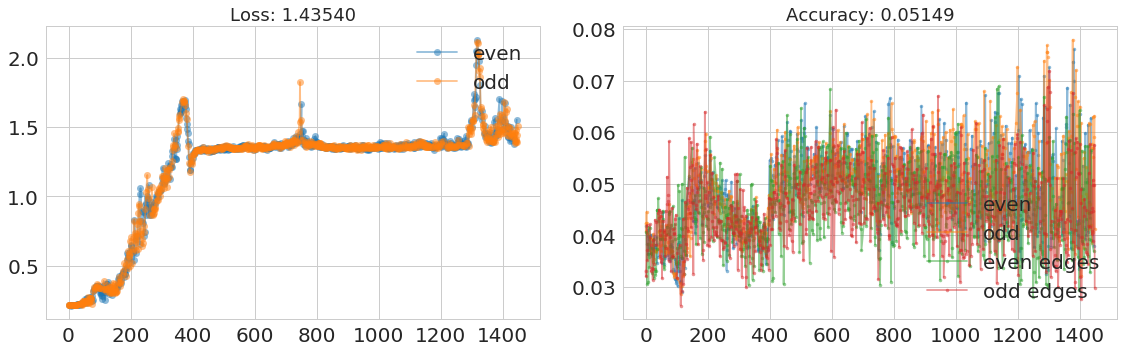

In [54]:
# Plot 1
fg, axs = plt.subplots(1, 2, figsize=(16, 5))

# === Loss ===
plt.sca(axs[0])
plot_losses(losses, lengths)

# === Accuracy ===
plt.sca(axs[1])
plot_accuarcy(scores, edges_edit_scores, lengths)

plt.tight_layout()
plt.savefig(NOTEBOOK_PATH.joinpath(f'{uniqie_id}-real_seq_adj-loss_acc.pdf').as_posix(), bbox_inches='tight')
plt.savefig(NOTEBOOK_PATH.joinpath(f'{uniqie_id}-real_seq_adj-loss_acc.png').as_posix(), dpi=72, bbox_inches='tight')

In [61]:
c = nn.Conv1d(10, 10, 3)

c.out_channels

10

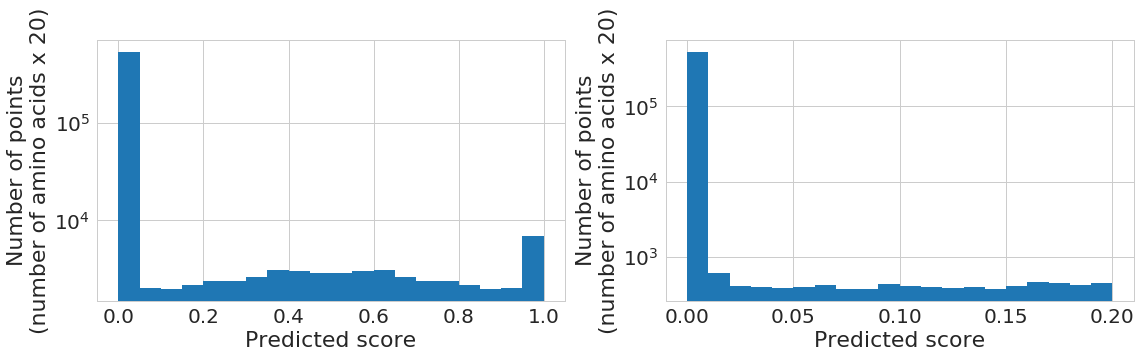

In [55]:
# Plot 2 
fg, axs = plt.subplots(1, 2, figsize=(16, 5))

# === All scores ===
plt.sca(axs[0])
hist_output(out, None)

# === Zoom in ===
plt.sca(axs[1])
hist_output(out, (0, 0.2))

plt.tight_layout()

# Other junk

In [232]:
num_aa_per_batch = 50_000
aa_per_prediction = 54

pos_ds_list = []

seq_len = 0
while seq_len < num_aa_per_batch:
    pos_row = next(positive_rowgen)
    if len(pos_row.sequence) < aa_per_prediction:
        continue
    pos_ds = to_gan(row_to_dataset(pos_row, 1))
    pos_ds_list.append(pos_ds)
    seq_len += len(pos_ds.seqs[0])
pos_dv = datasets_to_datavar(pos_ds_list)

In [239]:
seq = pos_dv[0][0]
adjs = pos_dv[1]

In [240]:
len(adjs)

317

In [1286]:
seq.size()

torch.Size([1, 5, 5])

torch.Size([32, 512, 4])
torch.Size([32, 512, 4])


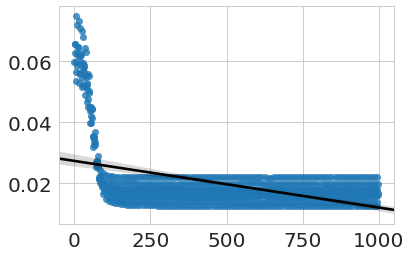

In [1266]:
in_features = 512
hidden_features = 32
n_unique_seqs = 10

class TestNet(nn.Module):
    def __init__(self):
        super().__init__()
        conv = nn.Conv1d(in_features, hidden_features, kernel_size=4, stride=1, padding=1, bias=False)
        print(conv.weight.shape)
        convt = nn.ConvTranspose1d(hidden_features, in_features, kernel_size=4, stride=1, padding=1, bias=False)
        print(conv.weight.shape)
        convt.weight.data = conv.weight
        self.conv = conv
        self.convt = convt

    def forward(self, x):
        x = self.conv(x)
#         print(x.shape)
        x = self.convt(x)
        x = F.softmax(x, 1)
        return x
    
net = TestNet()
loss = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

seqs = [(torch.rand(1, in_features, 4) > 0.99).float() for _ in range(n_unique_seqs)]

errors = []
for i in range(1000):
    optimizer.zero_grad()

    seq = seqs[i % n_unique_seqs]

    x = seq
    x = net(x)

    error = loss(x.view(-1, 1), seq.view(-1, 1))
    error.backward()
    
    optimizer.step()
    
    errors.append(error.data.numpy())
    
errors = np.vstack(errors).squeeze()
sns.regplot(np.arange(len(errors)), errors, line_kws={'color': 'k'})

In [1288]:
np.prod(seq.shape)

25

In [1569]:
seq[:, 30:40, :]

RuntimeError: dimension out of range (expected to be in range of [-1, 0], but got 2)

In [195]:
seq = pagnn.utils.random_sequence(1, 10, 4)
seq


(0 ,.,.) = 
   0   0   0   0
   0   1   0   0
   0   0   0   0
   0   0   0   0
   0   0   0   0
   0   0   0   1
   0   0   0   0
   1   0   0   0
   0   0   0   0
   0   0   1   0
[torch.FloatTensor of size (1,10,4)]

In [197]:
seq.transpose(1, 2).reshape(1, -1, 5).transpose(2, 1)


(0 ,.,.) = 
   0   0   0   0   0   0   0   1
   0   0   1   0   0   0   0   0
   0   1   0   0   0   0   0   0
   0   0   0   0   0   0   0   0
   0   0   0   0   0   1   0   0
[torch.FloatTensor of size (1,5,8)]

In [89]:
seq_avg = F.avg_pool1d(seq, kernel_size=2, ceil_mode=True)
seq_avg


(0 ,.,.) = 
  0  0  0  1
  0  0  0  0
  0  0  1  0
  0  1  0  0
  1  0  0  0
[torch.FloatTensor of size (1,5,4)]

In [92]:
seq_rec = F.upsample(seq_avg, scale_factor=2, mode='nearest')
seq_rec
# default


(0 ,.,.) = 
   0   0   0   0   0   0   1   1
   0   0   0   0   0   0   0   0
   0   0   0   0   1   1   0   0
   0   0   1   1   0   0   0   0
   1   1   0   0   0   0   0   0
[torch.FloatTensor of size (1,5,8)]

In [1581]:
F.avg_pool1d(seq_us, kernel_size=2)


(0 ,.,.) = 
  0.0000  0.1250  0.8750
  0.8750  0.1250  0.0000
  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000
  0.1250  0.7500  0.1250
[torch.FloatTensor of size (1,5,3)]

In [1561]:
F.avg_pool1d(seq_us, kernel_size=4, stride=2, padding=1)


(0 ,.,.) = 
  0.2500  0.5000  0.2500
  0.0000  0.0000  0.0000
  0.0000  0.2500  0.5000
  0.0000  0.0000  0.0000
  0.5000  0.2500  0.0000
[torch.FloatTensor of size (1,5,3)]

In [1545]:
F.upsample(seq, 7, mode='linear', align_corners=True)


(0 ,.,.) = 
  0.0000  0.3333  0.6667  1.0000  0.6667  0.3333  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.3333  0.6667  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  1.0000  0.6667  0.3333  0.0000  0.0000  0.0000  0.0000
[torch.FloatTensor of size (1,5,7)]

In [ ]:
nn.AvgPool1d

In [ ]:
F.avg_pool1d

In [1284]:
F.upsample(seq, scale_factor=2, mode='linear', align_corners=False )


(0 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.2500  0.7500  0.7500  0.2500  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.2500  0.7500  0.7500  0.2500
  1.0000  1.0000  1.0000  0.7500  0.2500  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2500  0.7500

Columns 9 to 9 
   0.0000
  0.0000
  0.0000
  0.0000
  1.0000
[torch.FloatTensor of size (1,5,10)]


(0 ,.,.) = 
  1  0  0  0  0
  0  1  0  0  0
  0  0  1  1  1
  0  0  0  0  0
[torch.FloatTensor of size (1,4,5)]

In [270]:
seq = pagnn.utils.random_sequence(1, 4, 5)
print(seq)

conv = nn.Conv1d(4, 4, 5, 2, 2)
convt = nn.ConvTranspose1d(4, 4, 5, 2, 1)

seqc = conv(seq)
print(seqc)

seqct = convt(seqc)
print(seqct)


(0 ,.,.) = 
  0  0  1  1  0
  0  0  0  0  1
  1  0  0  0  0
  0  1  0  0  0
[torch.FloatTensor of size (1,4,5)]


(0 ,.,.) = 
 -0.3646  0.0843 -0.1461
 -0.4204 -0.4138 -0.1101
 -0.3682 -0.0441  0.0272
  0.2157  0.2424  0.5570
[torch.FloatTensor of size (1,4,3)]


(0 ,.,.) = 
 -0.0523 -0.1517 -0.0755  0.1736 -0.0647 -0.0478 -0.0287
 -0.0539  0.0069  0.0285  0.1632 -0.0751  0.2107  0.0630
  0.3052  0.1612  0.4680  0.1629  0.4559  0.0477  0.3309
  0.0180 -0.0362  0.2294 -0.0218  0.1258 -0.0391  0.1564
[torch.FloatTensor of size (1,4,7)]



In [866]:
num_features = 5
seq_length = 6

in_features = 20
out_features = 20

ln = nn.Linear(in_features, out_features, bias=False)
ln.weight.data.set_(torch.eye(in_features, out_features))


seq = pagnn.utils.random_sequence(1, 5, 5)


x = seq
pad_amount = padding_amount(seq, 20)
print(pad_amount)

if pad_amount:
    x = F.pad(x, (0, pad_amount))

x = unfold_to(x, 20)
x = ln(x)
x = unfold_from(x, 5)

if pad_amount:
    x = x[:, :, :-pad_amount]
    
print(seq)
print(x)

assert (seq == x).all()

3

(0 ,.,.) = 
  1  0  0  0  0
  0  1  1  0  0
  0  0  0  0  0
  0  0  0  0  1
  0  0  0  1  0
[torch.FloatTensor of size (1,5,5)]


(0 ,.,.) = 
  1  0  0  0  0
  0  1  1  0  0
  0  0  0  0  0
  0  0  0  0  1
  0  0  0  1  0
[torch.FloatTensor of size (1,5,5)]



In [849]:
F.pad(seq, (0, pad_amount))

TypeError: torch.Size() takes an iterable of 'int' (item 2 is 'numpy.int64')

In [858]:
torch.Size((0, 20))

torch.Size([0, 20])

In [ ]:
torch.eye

In [39]:
out.view(1, 4, 20)


(0 ,.,.) = 

Columns 0 to 8 
   0.0000  1.0000  1.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000
  1.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000

Columns 9 to 17 
   1.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
  0.0000  0.0000  0.0000  1.0000  0.0000  1.0000  0.0000  0.0000  0.0000
  0.0000  1.0000  0.0000  0.0000  1.0000  0.0000  1.0000  1.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 18 to 19 
   1.0000  0.0002
  0.0000  0.0000
  0.0000  0.9998
  0.0000  0.0000
[torch.cuda.FloatTensor of size (1,4,20) (GPU 0)]

In [40]:
seq


(0 ,.,.) = 

Columns 0 to 18 
    0   1   1   0   0   1   0   0   0   1   0   1   0   0   0   0   0   1   1
   1   0   0   0   1   0   0   0   0   0   0   0   1   0   1   0   0   0   0
   0   0   0   1   0   0   0   1   1   0   1   0   0   1   0   1   1   0   0
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 19 
    0
   0
   1
   0
[torch.cuda.FloatTensor of size (1,4,20) (GPU 0)]

In [430]:
seq = pagnn.utils.random_sequence(1, 4, 21)
print(seq)

conv = nn.Conv1d(4, 8, kernel_size=4, stride=2, padding=0, bias=False)
_ = conv.weight.data.fill_(1)

convt = nn.ConvTranspose1d(8, 4, kernel_size=4, stride=2, padding=0, output_padding=0, bias=False)
_ = convt.weight.data.fill_(1)

seq = torch.cat([seq[:, :, -1:], seq, seq[:, :, :1]], 2)
# print(seq)

cseq = conv(seq)
print(cseq)

cseq = torch.cat([cseq[:, :, -1:], cseq, cseq[:, :, :1]], 2)
# print(cseq)

# cseq[0, 0, 4] = 100

ctseq = convt(cseq)
print(ctseq)


(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   1   0   0   1   0   1   0   0   1   0   0   0   0   0   0
   1   0   0   0   0   0   1   0   0   0   0   0   0   1   0   1   1   1   0
   0   1   0   0   0   1   0   0   1   0   0   1   0   0   1   0   0   0   0
   0   0   1   1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   1

Columns 19 to 20 
    1   1
   0   0
   0   0
   0   0
[torch.FloatTensor of size (1,4,21)]


(0 ,.,.) = 
   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4
[torch.FloatTensor of size (1,8,10)]


(0 ,.,.) = 

Columns 0 to 18 
   32  32  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
  32  32  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64  64
 

In [111]:
conv.weight


(0 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1

(1 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1

(2 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1

(3 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1

(4 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1

(5 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1

(6 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1

(7 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1
[torch.FloatTensor of size (8,4,4)]

In [19]:
seq = pagnn.utils.random_sequence(1, 8, 2)

convt = nn.ConvTranspose1d(8, 4, kernel_size=4, stride=2, padding=0, output_padding=0, bias=False)
_ = convt.weight.data.fill_(1)

convt(seq)


(0 ,.,.) = 
  1  1  2  2  1  1
  1  1  2  2  1  1
  1  1  2  2  1  1
  1  1  2  2  1  1
[torch.FloatTensor of size (1,4,6)]

In [13]:
convt(seq)


(0 ,.,.) = 
  1  2  2  1
  1  2  2  1
  1  2  2  1
  1  2  2  1
[torch.FloatTensor of size (1,4,4)]

In [14]:
raise Exception

Exception: 

In [ ]:
seq = pagnn.utils.random_sequence(1, 2048, 3)
conv = nn.Conv1d(2048, 1, kernel_size=1, stride=1, padding=0)
out = conv(Variable(seq))

In [ ]:
out.shape

In [ ]:
out2 = out.squeeze()
F.sigmoid(out).mean()

In [ ]:
1/64

In [ ]:
F.pad(seq, (5, 5), mode='replicate')

In [ ]:
def post_conv_dimensions(in_channels, out_channels, kernel_size, stride, padding, dilation):
    return (in_channels + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1


def apply_convs(seq, n_conv):
    in_channels = 20
    out_channels = 64
    convs = []
    for i in range(n_conv):
        print(in_channels, out_channels)
        conv = nn.Conv1d(in_channels, out_channels, kernel_size=4, stride=2, padding=0, bias=False)
        in_channels = out_channels
        out_channels *= 2
        convs.append(conv)

    in_channels = 20
    out_channels = 64
    for conv in convs:
        seq = torch.cat([seq[:, :, -1:], seq, seq[:, :, :1]], 2)
        seq = conv(seq)
        assert seq.shape[1] == out_channels
        in_channels = out_channels
        out_channels *= 2

    return seq
    
    
seq1 = pagnn.utils.gen_random_sequence(64, 20, 64)
seq1[:, 0, seq1.shape[2] - 1] = 100


seq2 = pagnn.utils.gen_random_sequence(64, 20, 32)

spacer = torch.zeros(64, 20, 4)

seq = torch.cat([seq1], dim=2)

res = apply_convs(Variable(seq), 6)  # 6

print(res.shape)

for i, v in enumerate(res.sum(1).sum(0)):
    print(f'{i:3}: {v.data[0]:10.4f}')

In [ ]:
1024 * 2048 * 4

In [ ]:
20 * 2 * 32 + \
64 * 2 * 64 + \
128 * 2 * 128 + \
256 * 2 * 256

In [ ]:
32 * 4 * 64 + \
64 * 4 * 128 + \
128 * 4 * 256 + \
256 * 4 * 512 + \
512 * 4 * 1024 + \
1024 * 4 * 2048 + \
2048